<a href="https://colab.research.google.com/github/adrikachowdhury/adrikachowdhury.github.io/blob/main/PneumoniaDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Install necessary packages**



In [ ]:
!pip install opendatasets --upgrade

## **Import  necessary libraries**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout ,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from IPython.display import Image, display
from tensorflow.keras.metrics import Precision
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.metrics import confusion_matrix
import opendatasets as od
import tensorflow as tf
import numpy as np
import os

## **Download the dataset from Kaggle**

In [ ]:
dataset_url="https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tahiyatislam
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:22<00:00, 110MB/s] 


## **Upload the kaggle.json file**

In [ ]:
files.upload()

#Set up Kaggle username and key
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

#Extract the dataset and unzip it
!unzip -q -o chest-xray-pneumonia.zip -x "__MACOSX/*"

# List folders
print(os.listdir('chest_xray'))

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:10<00:00, 235MB/s]
100% 2.29G/2.29G [00:10<00:00, 235MB/s]
caution: excluded filename not matched:  __MACOSX/*
['__MACOSX', 'chest_xray', 'val', 'test', 'train']


## **Define ImageDataGenerators and Directory paths**

In [ ]:
data_dir = 'chest_xray'

# Define paths
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

## **Creating ImageDataGenerators + Data Augmentation**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 3652 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## **Finding the number of samples for each class in every sets (train, validation, test)**

In [ ]:
# training set
train_normal = sum(train_generator.classes == 0)
train_pneumonia = sum(train_generator.classes == 1)

# validation set
val_normal = sum(val_generator.classes == 0)
val_pneumonia = sum(val_generator.classes == 1)

# test set
test_normal = sum(test_generator.classes == 0)
test_pneumonia = sum(test_generator.classes == 1)

print("Training set:")
print(f"Normal images: {train_normal}")
print(f"Pneumonia images: {train_pneumonia}")

print("\nValidation set:")
print(f"Normal images: {val_normal}")
print(f"Pneumonia images: {val_pneumonia}")

print("\nTest set:")
print(f"Normal images: {test_normal}")
print(f"Pneumonia images: {test_pneumonia}")

Training set:
Normal images: 939
Pneumonia images: 2713

Validation set:
Normal images: 402
Pneumonia images: 1162

Test set:
Normal images: 234
Pneumonia images: 390



## **Load dataset**

In [ ]:
# Load the dataset
dataset = ImageFolder(train_dir, transform=ToTensor())
test_dataset = ImageFolder(test_dir, transform=ToTensor())
print('Size of raw/train dataset:', len(dataset))
print('Size of test dataset:', len(test_dataset))

Size of raw/train dataset: 5216
Size of test dataset: 624


## **Introducing our base model (VGG16) and fine-tuning it**

In [ ]:
# Base model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Output shape of the base model
base_model_output_shape = base_model.output_shape
print("Base model output shape:", base_model_output_shape)

# Unfreeze layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 15

# Loop through the layers
for layer in base_model.layers[:-fine_tune_at]:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step
Base model output shape: (None, 7, 7, 512)


## **Transfer Learning**

In [ ]:
# Appending custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Add more dense layers if needed
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=predictions)

## **Setting Hyperparameters + model compilation**

In [ ]:
# Setting learning rate
initial_learning_rate = 0.0001

# Using Adam Optimizer
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name='precision')])

## **Providing the summary of our proposed model architecture**

In [ ]:
print("Model Summary:")
model.summary()

Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 12

## **Pictorial presentation of our proposed model**

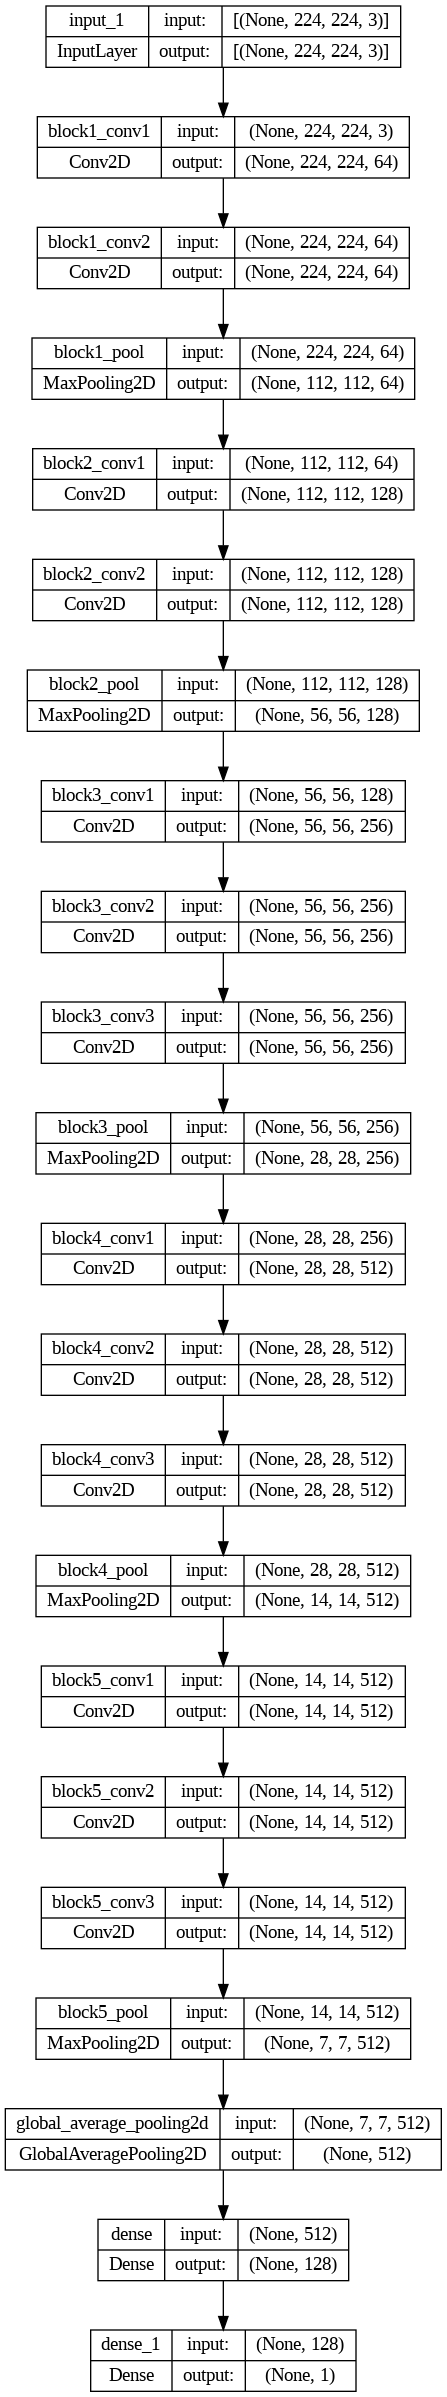

In [ ]:
# Generate & save the model structure image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the structure
Image('model_architecture.png')

## **Callbacks for learning rate scheduling, early stopping, model checkpoint**

In [ ]:
def scheduler(epoch, lr):
    if epoch < 15: # Constant learning rate for 1st 15 epochs
        return lr
    else: # Learning rate decay after 15 epochs are done
        return lr * tf.math.exp(-0.1)

learning_rate_schedule = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")

## **Training of our Proposed Model**

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[learning_rate_schedule, early_stopping, checkpoint_cb]
)

Epoch 1/30
114/114 [==============================] - ETA: 0s - loss: 0.3732 - accuracy: 0.8218 - precision: 0.8576

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - 154s 1s/step - loss: 0.3732 - accuracy: 0.8218 - precision: 0.8576 - val_loss: 0.4298 - val_accuracy: 0.7754 - val_precision: 0.9963 - lr: 1.0000e-04
Epoch 2/30
114/114 [==============================] - 119s 1s/step - loss: 0.2751 - accuracy: 0.8762 - precision: 0.9362 - val_loss: 0.2547 - val_accuracy: 0.8835 - val_precision: 0.9898 - lr: 1.0000e-04
Epoch 3/30
114/114 [==============================] - 128s 1s/step - loss: 0.2353 - accuracy: 0.9006 - precision: 0.9456 - val_loss: 0.2179 - val_accuracy: 0.9089 - val_precision: 0.9800 - lr: 1.0000e-04
Epoch 4/30
114/114 [==============================] - 130s 1s/step - loss: 0.1962 - accuracy: 0.9177 - precision: 0.9503 - val_loss: 0.2521 - val_accuracy: 0.8887 - val_precision: 0.9929 - lr: 1.0000e-04
Epoch 5/30
114/114 [==============================] - 131s 1s/step - loss: 0.1946 - accuracy: 0.9199 - precision: 0.9538 - val_loss: 0.2009 - val_accuracy: 0.9102 - val_precision: 0.9255 - lr: 1.

## **Further evaluation of our proposed model**

In [ ]:
best_model = tf.keras.models.load_model("best_model.h5")
test_loss, test_acc, test_precision = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')
print(f'Test Precision: {test_precision}')

20/20 [==============================] - 9s 459ms/step - loss: 0.3519 - accuracy: 0.9022 - precision: 0.8713
Test Accuracy: 0.9022436141967773
Test Loss: 0.3518877327442169
Test Precision: 0.8713318109512329


## **Calculating more significant Evaluation Metrices**

In [ ]:
# Confusion matrix and metrics
y_true = test_generator.classes
y_pred = (best_model.predict(test_generator) > 0.5).astype("int32").flatten()

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
recall = tp / (tp + fn)
f1_score = 2 * (test_precision * recall) / (test_precision + recall)

print(f'True Positives (TP): {tp}')
print(f'True Negatives (TN): {tn}')
print(f'False Positives (FP): {fp}')
print(f'False Negatives (FN): {fn}')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1_score * 100:.2f}%')

20/20 [==============================] - 6s 273ms/step
True Positives (TP): 272
True Negatives (TN): 63
False Positives (FP): 171
False Negatives (FN): 118
Recall: 69.74%
F1 Score: 77.47%


## **Accessing precision from history**

In [ ]:
precision = history.history['precision']
val_precision = history.history['val_precision']

# Print the precision for each epoch
for epoch, (prec, val_prec) in enumerate(zip(precision, val_precision), 1):
    print(f'Epoch {epoch}: Precision = {prec}, Validation Precision = {val_prec}')

Epoch 1: Precision = 0.8575927019119263, Validation Precision = 0.996268630027771
Epoch 2: Precision = 0.9362115859985352, Validation Precision = 0.9898374080657959
Epoch 3: Precision = 0.9456146955490112, Validation Precision = 0.9799618124961853
Epoch 4: Precision = 0.9502637386322021, Validation Precision = 0.9928861856460571
Epoch 5: Precision = 0.9537528157234192, Validation Precision = 0.9254868626594543
Epoch 6: Precision = 0.9638826251029968, Validation Precision = 0.9818016290664673
Epoch 7: Precision = 0.9718679785728455, Validation Precision = 0.991062581539154
Epoch 8: Precision = 0.9691497087478638, Validation Precision = 0.8828549385070801
Epoch 9: Precision = 0.9712041616439819, Validation Precision = 0.9451013803482056
Epoch 10: Precision = 0.9745984077453613, Validation Precision = 0.9392173290252686
Epoch 11: Precision = 0.9763867855072021, Validation Precision = 0.9770318269729614
Epoch 12: Precision = 0.976457417011261, Validation Precision = 0.9942638874053955
Epoc

## **Display sample predictions**

In [ ]:
def display_sample_predictions(generator, model, num_samples=5):
    x_batch, y_batch = next(generator)
    preds = model.predict(x_batch)
    plt.figure(figsize=(15, 10))

    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_batch[i])
        true_label = 'Pneumonia' if y_batch[i] else 'Normal'
        predicted_label = 'Pneumonia' if preds[i] > 0.5 else 'Normal'
        plt.title(f'True: {true_label}\nPred: {predicted_label}')
        plt.axis('off')

    plt.show()

1/1 [==============================] - 0s 176ms/step


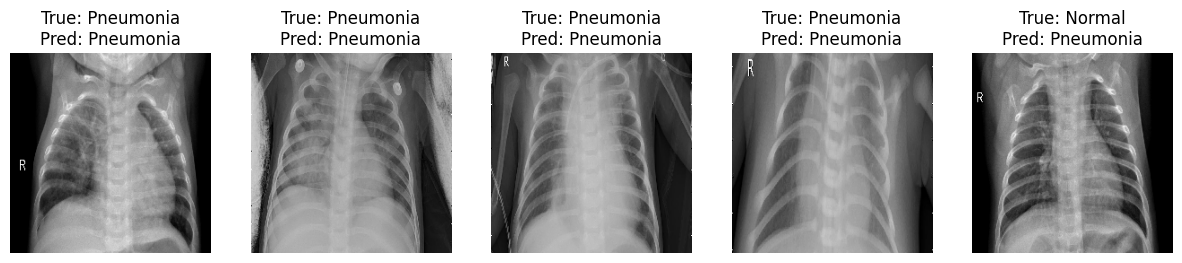

In [ ]:
# Sample predictions on test data
display_sample_predictions(test_generator, best_model)

In [ ]:
predictions = model.predict(test_generator)
predicted_labels = ['Pneumonia' if pred > 0.5 else 'Normal' for pred in predictions]
print("Predicted labels:", predicted_labels)

20/20 [==============================] - 6s 316ms/step
Predicted labels: ['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Normal', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Normal', 'Normal', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Normal', 'Normal', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Normal', 'Pneumonia', '

## **Plotting Training Vs. Validation Accuracy Graph**

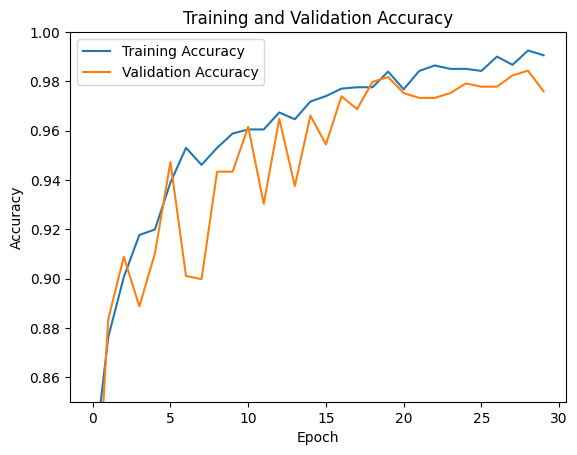

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.85, 1.0])
plt.title('Training and Validation Accuracy')
plt.show()

## **Plotting Training Vs. Validation Loss Graph**

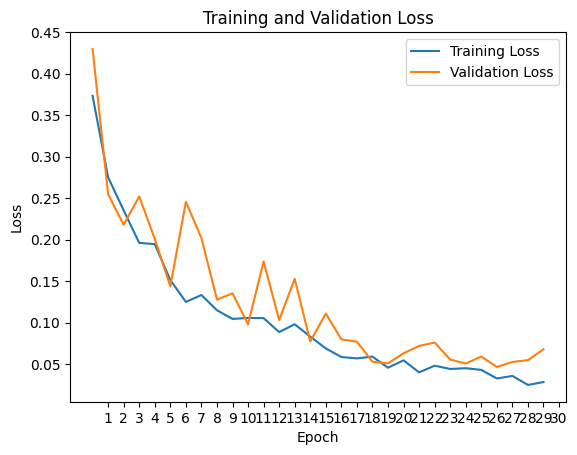

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
epochs = len(history.history['loss'])
tick_values = range(1, epochs + 1)
plt.xticks(tick_values)
plt.title('Training and Validation Loss')
plt.show()

## **Plotting Training Vs. Validation Precision Graph**

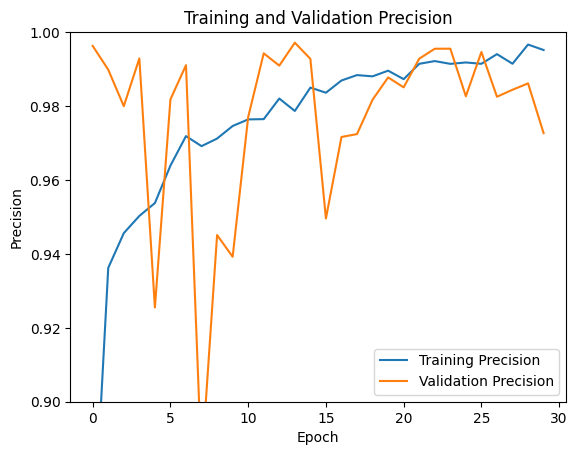

In [ ]:
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.ylim([0.90, 1.0])
plt.title('Training and Validation Precision')
plt.show()

## **Testing on an unseen image**

In [ ]:
# Predict an unseen image
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = np.expand_dims(img, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0,1]
    return img_array

In [ ]:
def predict_image(img_path):
    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Prediction
    prediction = best_model.predict(img_array)
    predicted_class = int(prediction[0] > 0.5)

    # Cass values -> labels
    class_labels = {0: 'Normal', 1: 'Pneumonia'}
    predicted_label = class_labels[predicted_class]

    # Display image alongside prediction
    plt.imshow(load_img(img_path))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()
    print(f"Predicted class label for the given image is: {predicted_class} ({predicted_label})")

In [ ]:
# Upload an image & predict
uploaded = files.upload()

for img_path in uploaded.keys():
    predict_image(img_path)

NameError: name 'files' is not defined

## **Save the model**

In [ ]:
model.save('pneumonia_detection_model.h5')